In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["exotic", "cozy", "luxurious", "nature_freindly", "modern" ]

print(torch.__version__)

2.3.0+cpu


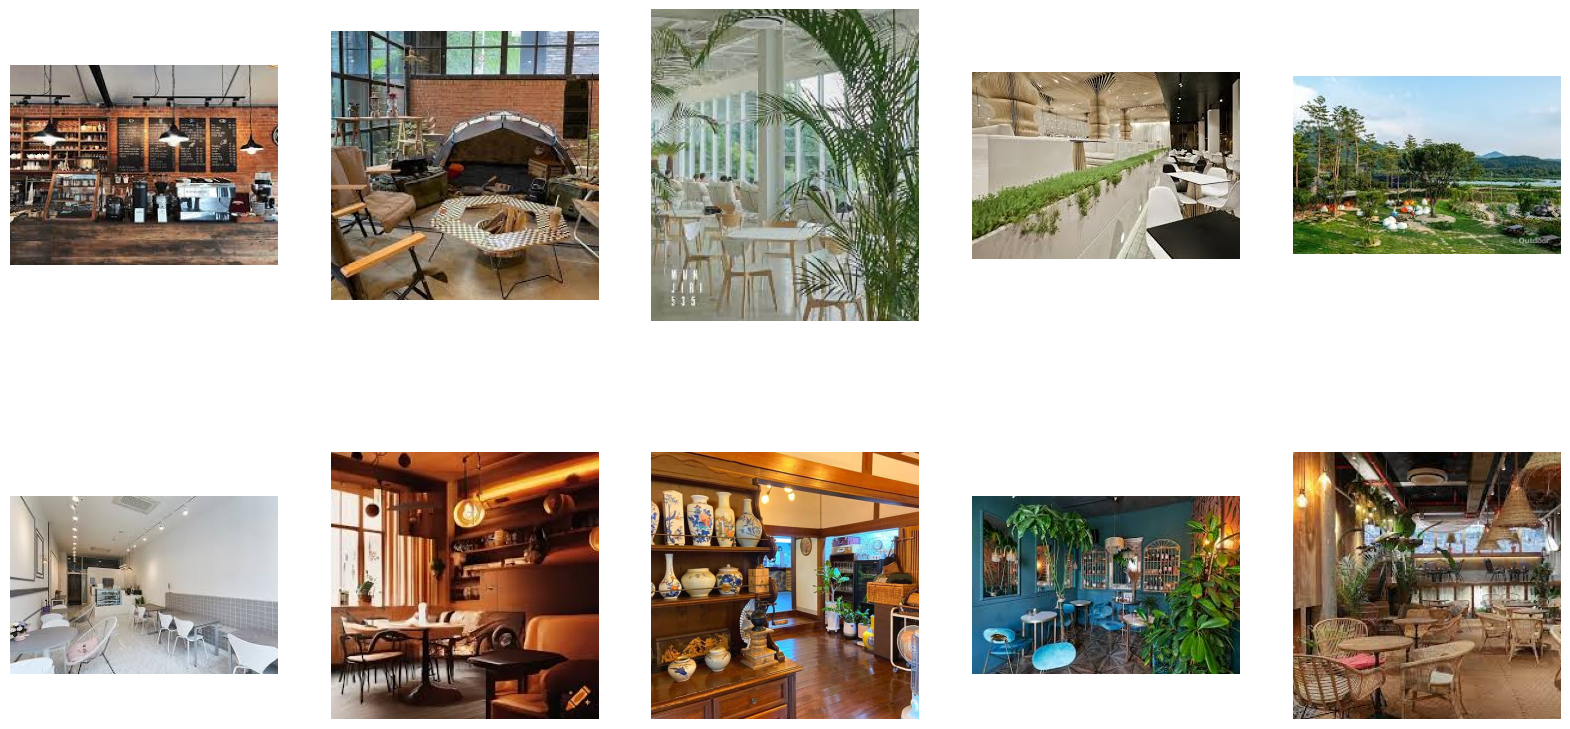

In [2]:
import os
import random

image_folder_path = 'original'

# 폴더 내의 모든 파일 목록을 가져옵니다.
image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]

# 랜덤하게 10개의 이미지를 선택합니다. (이미지 수가 10개 미만일 경우 모든 이미지를 선택)
selected_images = random.sample(image_files, min(10, len(image_files)))

# 선택된 이미지를 출력합니다.
plt.figure(figsize=(20, 10))  # 출력될 이미지 크기를 설정합니다.
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)  # 2행 5열의 그리드에서 이미지를 출력합니다.
    plt.imshow(img)
    plt.axis('off')  # 축을 보이지 않게 합니다.
plt.show()

In [3]:
df = pd.DataFrame({"image": sorted([int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df["image"] = df["image"].astype(str) + ".jpg"

df.to_csv("data.csv", index=False)
# 데이터프레임의 처음 10개 및 마지막 10개 행 출력
print(df.head(10))
print(df.tail(10))

    image
0   1.jpg
1   2.jpg
2   3.jpg
3   4.jpg
4   5.jpg
5   6.jpg
6   7.jpg
7   8.jpg
8   9.jpg
9  10.jpg
       image
365  366.jpg
366  367.jpg
367  368.jpg
368  369.jpg
369  370.jpg
370  371.jpg
371  372.jpg
372  373.jpg
373  374.jpg
374  375.jpg


52.jpg


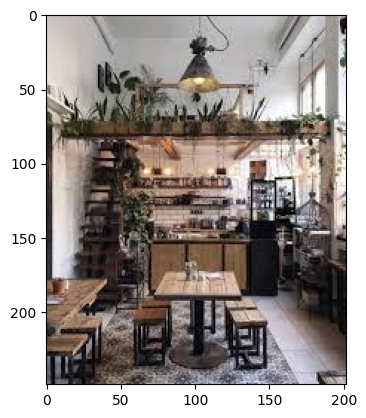

In [4]:
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd['image']
    label = fd[1:].to_numpy()
    print(image)
    image = Image.open("original/" + image)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes = np.array(classLabels)[label.astype(np.bool_)]  # np.bool 대신 np.bool_ 사용
    for i, s in enumerate(classes):
        ax.text(0, i * 20, s, verticalalignment='top', color="white", fontsize=16, weight='bold')
    plt.show()

visualizeImage(51)

In [5]:
#데이터 피딩을 위한 작업

class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):

    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms

  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)

    if self.transforms is not None:
      image = self.transforms(image)
    return image,label

  def __len__(self):
    return len(self.df)

In [6]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) ,
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("original") , transform)

# train, valid 셋 구분

valid_no = int(len(dataset)*0.12)
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 330 valset len 45


In [7]:
# resnet50모델로 전이학습 하겠습니다.

model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)

c:\Users\djdj4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\djdj4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048


In [8]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
top_head = create_head(num_features , len(classLabels)) # because ten classes
top_head = top_head.to(device)
model.fc = top_head # replace the fully connected layer

cpu


In [9]:
# 모델의 바닥 일부를 freezing합니다.
# 'conv1', 'bn1', 'relu', 'maxpool', 'layer1'을 포함한 초기 레이어를 freeze

for name, child in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        break  # 'layer1' 다음 레이어에 도달하면 loop 종료


In [10]:
#loss 함수와 옵티마이져, 스케줄로를 정의
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [11]:
#모델 로드 및 추론용으로 세팅
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)
/content/LatestCheckpoint.pt
'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0009999999999999983
    maximize: False
    weight_decay: 0
)

In [12]:
#valid 데이터로 추론

image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2

In [13]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0)
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  [ classLabels[i] for i, x in enumerate(actual) if int(x) == 1 ]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')

  classes =  [ classLabels[i] for i, x in enumerate(pred) if int(x) == 1 ]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')

  plt.show()

전경 분류

In [14]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (c:\Users\djdj4\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\preprocessing\image\__init__.py)

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 705 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

모델 불러오는 파트

In [ ]:
# architecture and weights from HDF5
model = load_model('model.h5')

# architecture from JSON, weights from HDF5
with open('architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('weights.h5')

분류 파트

함수

In [ ]:
def predict_label(image, model, classLabels):
    # 이미지 전처리
    img_array = preprocess_input(np.array(image.resize((224, 224)))[np.newaxis, :])

    # 모델 예측
    pred_probs = model.predict(img_array)

    # 예측된 클래스 인덱스 찾기
    predicted_class_index = np.argmax(pred_probs[0])

    # 예측된 클래스 라벨 가져오기
    predicted_label = classLabels[predicted_class_index]

    return predicted_label

1/1 [==============================] - 0s 172ms/step
Predicted Label: exotic


In [ ]:
# 이미지 경로
image_path = "original/33.jpg"
image = Image.open(image_path)

# 이미지에 대한 라벨 예측
predicted_label = predict_label(image, model, classLabels)

# 결과 출력
print("Predicted Label:", predicted_label)

전경 파트

함수

In [ ]:
def predict_cafe(image_path, model):
    # 이미지 로드 및 전처리
    img = Image.open(image_path).resize((224, 224))
    img_array = preprocess_input(np.array(img)[np.newaxis, :])

    # 모델 예측
    pred_probs = model.predict(img_array)

    # 예측 결과 해석 파트
    predicted_label = "Cafe" if pred_probs[0][0] > 0.8 else "Non-Cafe"

    #카페인지 아닌지
    return predicted_label

In [ ]:
#이미지 경로 -> 미리 지정해놓고 사용
image_path = ".jpg"

# 함수 호출
predicted_label, confidence = predict_cafe(image_path, model)

In [ ]:
print("Predicted Label:", predicted_label)

Predicted Label: Cafe
